In [137]:
%reset -f
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

import seaborn as sns
import os

import latexify

In [29]:

from scipy.spatial import distance


def compute_distances(data):
    prey = data[data['isPredator'] == 0]
    predator = data[data['isPredator'] == 1]
    
    # Compute distances among predator neighbors
    predator_positions = predator.groupby('step')[['x', 'y']].apply(lambda x: x.values.tolist())
    predator_distances = predator_positions.apply(lambda x: np.mean(distance.pdist(x)))
    
    # Compute distances between prey and predator
    swarm_pred_center_per_step = predator.groupby('step')[['x', 'y']].mean()
    swarm_prey_center_per_step = prey.groupby('step')[['x', 'y']].mean()
    prey_predator_distances = np.sqrt((swarm_prey_center_per_step['x'] - swarm_pred_center_per_step['x'])**2 + 
                                     (swarm_prey_center_per_step['y'] - swarm_pred_center_per_step['y'])**2)
                                     
    
    # Compute order of the predators
    predator_order = predator.groupby('step')['theta'].apply(compute_order_parameter2)
    
    return predator_distances, prey_predator_distances, predator_order

def compute_order_parameter2(group: pd.DataFrame) -> float:
    """
    Compute the order parameter for the given group
    """
    N = len(group)  # use the length of the group
    sum_exp = np.sum(np.exp(1j * group))  # sum of complex exponentials of the angles
    order_parameter = np.abs(sum_exp) / N  # order parameter
    return order_parameter

# @latexify.function
def compute_order_parameter(group: pd.DataFrame) -> pd.Series:
    """
    Compute the order parameter for the given group
    """
    
    # print(group)
    N = len(group)  # use the length of the group
    sum_exp = np.sum(np.exp(1j * group))  # sum of complex exponentials of the angles
    order_parameter = np.abs(sum_exp) / N  # order parameter
    return pd.Series([order_parameter] * len(group), index=group.index)


compute_order_parameter

def plot_data(data: pd.DataFrame, title: str=""):


    prey     = data[data['isPredator'] == 0]
    predator = data[data['isPredator'] == 1]

    steps = data['step'].astype(int).unique()

    trajectory_prey     = prey.groupby('step')[['x', 'y']].mean()
    trajectory_predator = predator.groupby('step')[['x', 'y']].mean()


    last_steps_positions_predators = predator[predator['step'] == predator['step'].max()]
    last_steps_positions_prey      = prey[prey['step'] == prey['step'].max()]


    prey['order_parameter']     = prey.groupby('step')['theta'].transform(compute_order_parameter)
    predator['order_parameter'] = predator.groupby('step')['theta'].transform(compute_order_parameter)


    swarm_pred_center_per_step = predator.groupby('step')[['x', 'y']].mean()
    swarm_prey_center_per_step = prey.groupby('step')[['x', 'y']].mean()

    distance = np.sqrt((swarm_prey_center_per_step['x'] - swarm_pred_center_per_step['x'])**2 + (swarm_prey_center_per_step['y'] - swarm_pred_center_per_step['y'])**2)

    # velocity use vx and vy
    predator['speed'] = np.sqrt(predator['vx']**2 + predator['vy']**2)
    prey['speed'] = np.sqrt(prey['vx']**2 + prey['vy']**2)


    mean_speed_pred_per_step = predator.groupby('step')['speed'].mean()
    mean_speed_prey_per_step = prey.groupby('step')['speed'].mean()

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    plt.suptitle(title)

    # plot trajectory
    axs[0].plot(trajectory_prey['x'], trajectory_prey['y'], label='Prey')
    axs[0].plot(trajectory_predator['x'], trajectory_predator['y'], label='Predator')

    axs[0].scatter(last_steps_positions_prey['x'], last_steps_positions_prey['y'], label='Prey', color='blue')
    # change color of the predator if no sensor
    predators_with_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 1]
    predators_without_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 0]
    axs[0].scatter(predators_with_sensor['x'], predators_with_sensor['y'], label='Predator', color='red')
    axs[0].scatter(predators_without_sensor['x'], predators_without_sensor['y'], label='Predator no sensor', color='green')

    axs[0].quiver(last_steps_positions_prey['x'], last_steps_positions_prey['y'], np.cos(last_steps_positions_prey['theta']), np.sin(last_steps_positions_prey['theta']), color='blue')
    axs[0].quiver(last_steps_positions_predators['x'], last_steps_positions_predators['y'], np.cos(last_steps_positions_predators['theta']), np.sin(last_steps_positions_predators['theta']), color='red')

    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[0].set_title('Trajectory')
    axs[0].legend()

    # plot order parameter
    axs[1].plot(prey['step'], prey['order_parameter'], label='Prey')
    axs[1].plot(predator['step'], predator['order_parameter'], label='Predator')
    axs[1].set_xlabel('step')
    axs[1].set_ylabel('order_parameter')
    axs[1].set_title('Order Parameter')
    axs[1].legend()


    # plot average distance between the two swarms
    axs[2].plot(steps, distance)
    axs[2].set_xlabel('step')
    axs[2].set_ylabel('distance')
    axs[2].set_title('Distance between the two swarms')

    # plot average distance between the two swarms
    axs[3].plot(steps, mean_speed_pred_per_step, label='Predator')
    axs[3].plot(steps, mean_speed_prey_per_step, label='Prey')
    axs[3].set_xlabel('step')
    axs[3].set_ylabel('speed')
    axs[3].set_title('Mean Speed')
    axs[3].legend()

# Part 1


In [60]:
experiment_id_ =  [str(i) for i in range(1, 1+1)]
N_preys                    = [60]
N_agent                    = [60]
min_distance               = [6.0] # was trying with 6.
         # testing 1:1, 2:1, 3:2 ratio
sensing_range              = [5, 3, 4] # prey
sensor_range               = [5, 6]    # predator
percentage_no_sensor       = [0.0, 0.75, 0.99]
# kappas                     = [3]
total_steps_per_simulation = 10000
pdm                        = True
kappas                     = [3.0]
Dps                        = [3.0]
Dpms                       = [3.0]

from fractions import Fraction
from itertools import product

# Calculate ratios and convert to strings
ratios = [Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range)]
ratios_str = [f"{r.numerator}:{r.denominator}" for r in ratios]
print(ratios_str)

path = 'dataPreyPredator/ratioTest'

# dfs = {(exp_id, str(perc)): [] for exp_id in experiment_id_ for perc in percentage_no_sensor}
# dfs = {ratio: [] for ratio in ratios_str}
dfs = {}
i = 1
# Calculate ratios and convert to strings
ratios = [Fraction(sensor, sensing).limit_denominator() for sensing, sensor in product(sensing_range, sensor_range)]
ratios_str = [f"{r.numerator}:{r.denominator}" for r in ratios]

path = 'dataPreyPredator/ratioTest'
dfs = {ratio_str: [] for ratio_str in ratios_str}

for experiment_id in experiment_id_:
    for ratio_str in ratios_str:
        for n_prey in N_preys:
            for perc_no_sensor in percentage_no_sensor:
                for n_agent in N_agent:
                    for s_range in sensing_range:
                        for sensor_r in sensor_range:
                            for min_d in min_distance:
                                for kappa in kappas:
                                    for Dp in Dps:
                                        for Dpm in Dpms:
                                            try:
                                                data = pd.read_csv(
                                                    f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dpm}]_exp[{experiment_id}].csv'
                                                )
                                                current_ratio = f'{Fraction(sensor_r, s_range).numerator}:{Fraction(sensor_r, s_range).denominator}'
                                                if current_ratio == ratio_str:
                                                    dfs[ratio_str].append(data)
                                                    # plot_data(data, f'ratio: {ratio_str}, experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor},i: {i}')
                                                    # i += 1
                                            except FileNotFoundError:
                                                print(
                                                    f'File not found for experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor}'
                                                )

['1:1', '6:5', '5:3', '2:1', '5:4', '3:2']


In [62]:
dfs.keys()

dict_keys(['1:1', '6:5', '5:3', '2:1', '5:4', '3:2'])

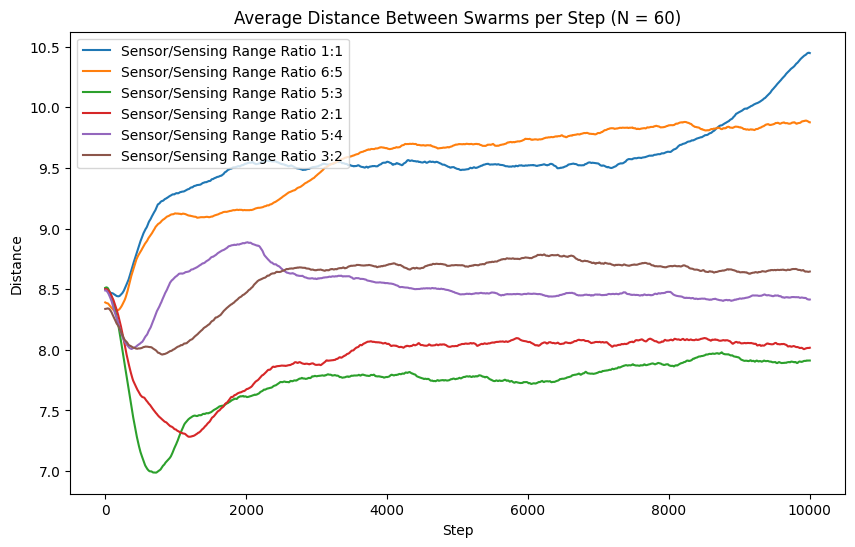

In [64]:

# ['1:1', '6:5', '5:3', '2:1', '5:4', '3:2']
avg_distances00 = {}
avg_distances75 = {}
avg_distances99 = {}
# Plotting for each ratio separately

for ratio_str, ratio_data in dfs.items():
    ratio_avg_distances = []
    for data in ratio_data:
        prey = data[data['isPredator'] == 0]
        predator = data[data['isPredator'] == 1]

        swarm_pred_center_per_step = predator.groupby('step')[['x', 'y']].mean()
        swarm_prey_center_per_step = prey.groupby('step')[['x', 'y']].mean()
        
        distance = np.sqrt((swarm_prey_center_per_step['x'] - swarm_pred_center_per_step['x'])**2 + 
                           (swarm_prey_center_per_step['y'] - swarm_pred_center_per_step['y'])**2)

        ratio_avg_distances.append(distance)

    avg_distances00[ratio_str] = np.mean(ratio_avg_distances, axis=0)

    # for i, avg_distance_per_step in enumerate(ratio_avg_distances):
    #     ax.plot(range(total_steps_per_simulation), avg_distance_per_step, label=f"Experiment {i+1}")
# print(avg_distances00)
fig, ax = plt.subplots(figsize=(10, 6))
for ratio_str, avg_distance_per_step in avg_distances00.items():
    ax.plot(range(total_steps_per_simulation), avg_distance_per_step, label=f"Sensor/Sensing Range Ratio {ratio_str}")

ax.set_title('Average Distance Between Swarms per Step (N = 60)')
ax.set_xlabel('Step')
ax.set_ylabel('Distance')
ax.legend()
plt.show()

        

In [35]:
experiment_id_ =  [str(i) for i in range(1, 10+1)]
N_preys                    = [60]
N_agent                    = [60]
min_distance               = [6.0]
sensing_range              = [3]
sensor_range               = [6]
percentage_no_sensor       = [0.0, 0.75, 0.99]
kappas                     = [0.5, 1.0, 2.0, 3.0]
Dps                        = [3.0]
Dpms                       = [3.0]
pdm                        = True
total_steps_per_simulation = 8000
path = 'dataPreyPredator/kappas'

dfs = {experiment_id: {} for experiment_id in experiment_id_}
i = 1
for experiment_id in experiment_id_:
    for kappa in kappas:
        for n_prey in N_preys:
            for perc_no_sensor in percentage_no_sensor:
                for n_agent in N_agent:
                    for s_range in sensing_range:
                        for sensor_r in sensor_range:
                            for min_d in min_distance:
                                for Dp in Dps:
                                    for Dpm in Dpms:
                                        try:
                                            data = pd.read_csv(
                                                        #  Agents[60]_Preys[60]_steps[8000]_kappa[0.5]_precentageNoSensor[0.0]_minDistance[6.0]_sensingRange[3]_sensorRange[6]_pdm[True]_DpPdm[3.0]_exp[1]
                                                f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dpm}]_exp[{experiment_id}].csv'
                                            )
                                            dfs[experiment_id][(kappa, perc_no_sensor)] = data
                                            # plot_data(data, f'kappa: {kappa}, experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor},i: {i}')
                                            # i += 1
                                        except FileNotFoundError:
                                            print(
                                                f'File not found for experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor}'
                                            )



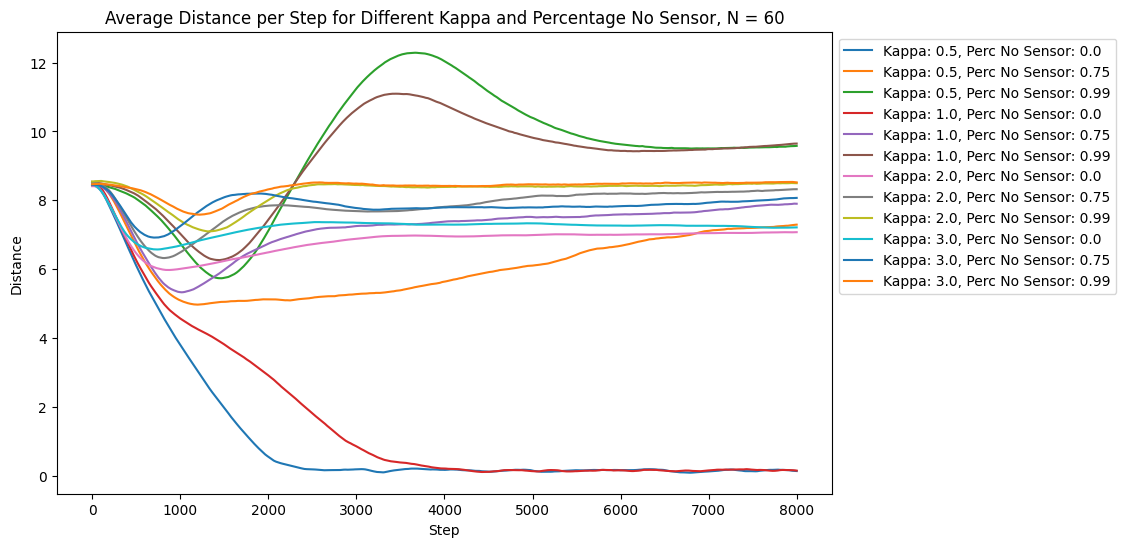

In [36]:
# Step 1: Aggregate the data across all experiment IDs for each condition
avg_distance_per_condition = {}
for exp_id in dfs.keys():
    for key, data in dfs[exp_id].items():
        condition = key  # condition is a tuple (kappa, perc_no_sensor)
        if condition not in avg_distance_per_condition:
            avg_distance_per_condition[condition] = []
        prey = data[data['isPredator'] == 0]
        predator = data[data['isPredator'] == 1]
        swarm_pred_center_per_step = predator.groupby('step')[['x', 'y']].mean()
        swarm_prey_center_per_step = prey.groupby('step')[['x', 'y']].mean()
        distance = np.sqrt((swarm_prey_center_per_step['x'] - swarm_pred_center_per_step['x'])**2 + 
                           (swarm_prey_center_per_step['y'] - swarm_pred_center_per_step['y'])**2)
        avg_distance_per_condition[condition].append(distance)

# Step 2: Calculate the average distance per step for each condition
avg_distance_per_step = {condition: np.mean(distances, axis=0) for condition, distances in avg_distance_per_condition.items()}

# Step 3: Plot the averages per step with legends representing kappa with percentage no sensor
plt.figure(figsize=(10, 6))  # Adjust the figure size as per your preference
for condition, avg_distance in avg_distance_per_step.items():
    kappa, perc_no_sensor = condition
    label = f'Kappa: {kappa}, Perc No Sensor: {perc_no_sensor}'
    plt.plot(range(len(avg_distance)), avg_distance, label=label)

plt.xlabel('Step')
plt.ylabel('Distance')
plt.title('Average Distance per Step for Different Kappa and Percentage No Sensor, N = 60')

# Place legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [32]:
# DPS ADM
experiment_id_ =  [str(i) for i in range(1, 10+1)]
N_preys                    = [60]
N_agent                    = [60]
min_distance               = [6.0]
sensing_range              = [3]
sensor_range               = [6]
percentage_no_sensor       = [0.0, 0.75, 0.99]
kappas                     = [3.0]
Dps                        = [3.0]
Dpms                       = [2.0, 3.0, 4.0]
pdm                        = True
total_steps_per_simulation = 8000
path = 'dataPreyPredator/Dp_padm'

dfs = {experiment_id: {} for experiment_id in experiment_id_}
i = 1
for experiment_id in experiment_id_:
    for kappa in kappas:
        for n_prey in N_preys:
            for perc_no_sensor in percentage_no_sensor:
                for n_agent in N_agent:
                    for s_range in sensing_range:
                        for sensor_r in sensor_range:
                            for min_d in min_distance:
                                for Dp in Dps:
                                    for Dpm in Dpms:
                                        try:
                                            data = pd.read_csv(
                                                        #  Agents[60]_Preys[60]_steps[8000]_kappa[0.5]_precentageNoSensor[0.0]_minDistance[6.0]_sensingRange[3]_sensorRange[6]_pdm[True]_DpPdm[3.0]_exp[1]
                                                f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dpm}]_exp[{experiment_id}].csv'
                                            )
                                            dfs[experiment_id][(Dpm, perc_no_sensor)] = data
                                            # plot_data(data, f'kappa: {kappa}, experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor},i: {i}')
                                            # i += 1
                                        except FileNotFoundError:
                                            print(
                                                f'File not found for experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor}'
                                            )




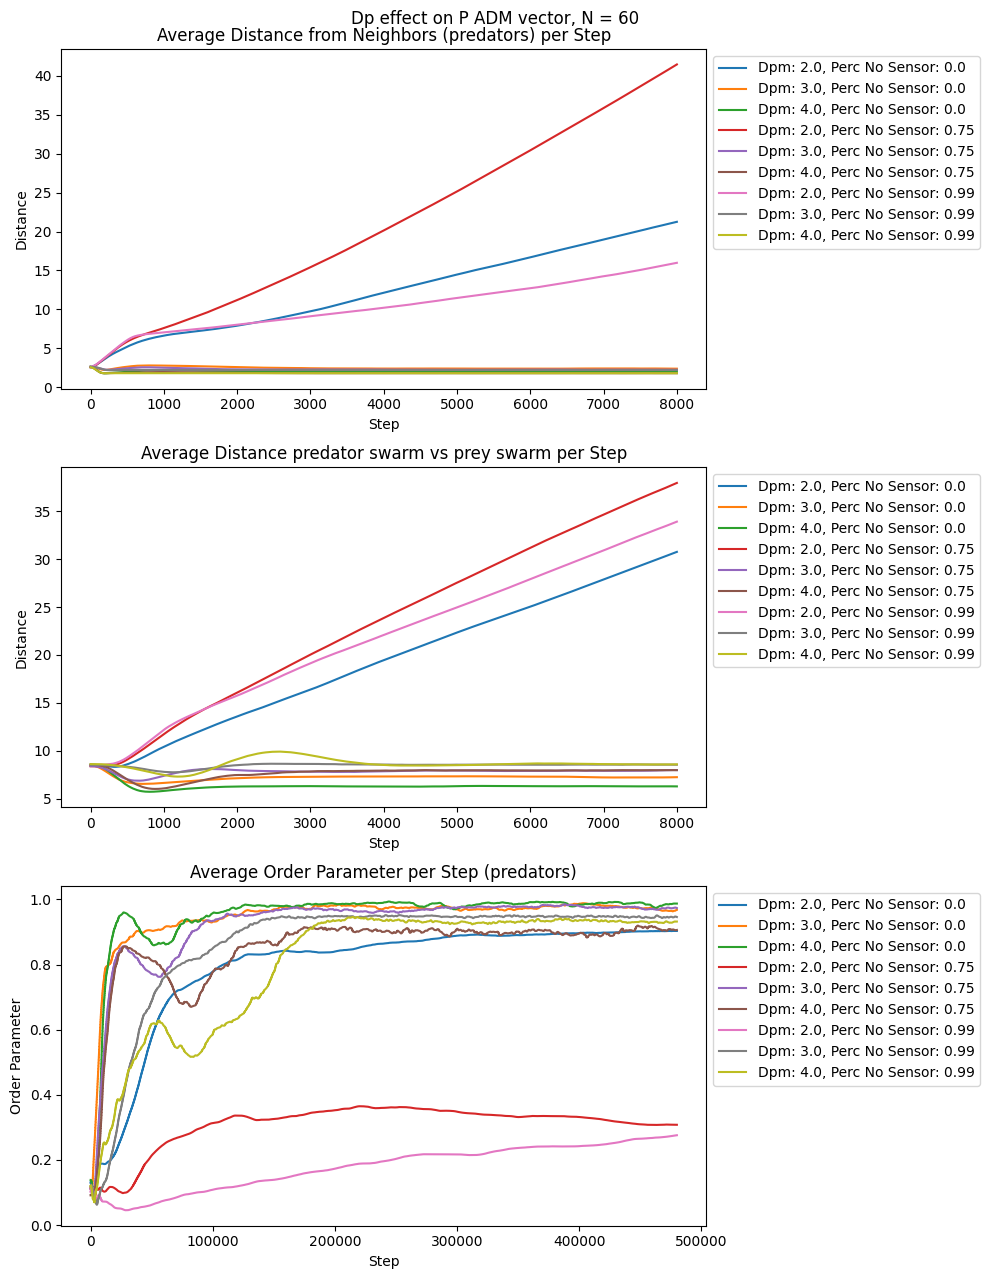

In [33]:


average_distance_from_neighbors_per_condition = {}
average_distance_from_prey_per_condition = {}
average_order_parameter_per_condition = {}




for exp_id in dfs.keys():
    for key, data in dfs[exp_id].items():
        condition = key  # condition is a tuple (Dpm, perc_no_sensor)
        if condition not in average_distance_from_neighbors_per_condition:
            average_distance_from_neighbors_per_condition[condition] = []
            average_distance_from_prey_per_condition[condition] = []
            average_order_parameter_per_condition[condition] = []
        predator_distances, prey_predator_distances, predator_order = compute_distances(data)
        average_distance_from_neighbors_per_condition[condition].append(predator_distances)
        average_distance_from_prey_per_condition[condition].append(prey_predator_distances)
        average_order_parameter_per_condition[condition].append(predator_order)

# Find the maximum number of steps across all conditions
max_steps = max(max(len(distances) for distances in condition_dict.values()) for condition_dict in [average_distance_from_neighbors_per_condition, average_distance_from_prey_per_condition, average_order_parameter_per_condition])

# Pad the arrays in each condition dictionary
for condition_dict in [average_distance_from_neighbors_per_condition, average_distance_from_prey_per_condition, average_order_parameter_per_condition]:
    for condition, distances in condition_dict.items():
        for i in range(len(distances)):
            if len(distances[i]) < max_steps:
                distances[i] = np.pad(distances[i], (0, max_steps - len(distances[i])), 'constant', constant_values=np.nan)

# Calculate the average distance from neighbors, from prey, and order parameter per step for each condition
average_distance_from_neighbors_per_step = {condition: np.nanmean(distances, axis=0) for condition, distances in average_distance_from_neighbors_per_condition.items()}
average_distance_from_prey_per_step = {condition: np.nanmean(distances, axis=0) for condition, distances in average_distance_from_prey_per_condition.items()}
average_order_parameter_per_step = {condition: np.nanmean(order, axis=0) for condition, order in average_order_parameter_per_condition.items()}
fig, axes = plt.subplots(3, 1, figsize=(10, 13))
for condition, avg_distance in average_distance_from_neighbors_per_step.items():
    Dpm, perc_no_sensor = condition
    label = f'Dpm: {Dpm}, Perc No Sensor: {perc_no_sensor}'
    axes[0].plot(range(len(avg_distance)), avg_distance, label=label)

for condition, avg_distance in average_distance_from_prey_per_step.items():
    Dpm, perc_no_sensor = condition
    label = f'Dpm: {Dpm}, Perc No Sensor: {perc_no_sensor}'
    axes[1].plot(range(len(avg_distance)), avg_distance, label=label)

for condition, avg_order in average_order_parameter_per_step.items():
    Dpm, perc_no_sensor = condition
    label = f'Dpm: {Dpm}, Perc No Sensor: {perc_no_sensor}'
    axes[2].plot(range(len(avg_order)), avg_order, label=label)


axes[0].set_title('Average Distance from Neighbors (predators) per Step')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Distance')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[1].set_title('Average Distance predator swarm vs prey swarm per Step')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Distance')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_title('Average Order Parameter per Step (predators)')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Order Parameter')
axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make space for the suptitle
plt.suptitle('Dp effect on P ADM vector, N = 60')
plt.show()

In [67]:
# DPS normal pvector
experiment_id_ =  [str(i) for i in range(1, 10+1)]
N_preys                    = [60]
N_agent                    = [60]
min_distance               = [6.0]
sensing_range              = [3]
sensor_range               = [6]
percentage_no_sensor       = [0.0, 0.75, 0.99]
kappas                     = [3.0]
Dps                        = [2.0, 3.0, 4.0]
Dpms                       = [3.0]
pdm                        = False
total_steps_per_simulation = 8000
path = 'dataPreyPredator/Dp_normalpvector'

dfs = {experiment_id: {} for experiment_id in experiment_id_}
i = 1
for experiment_id in experiment_id_:
    for kappa in kappas:
        for n_prey in N_preys:
            for perc_no_sensor in percentage_no_sensor:
                for n_agent in N_agent:
                    for s_range in sensing_range:
                        for sensor_r in sensor_range:
                            for min_d in min_distance:
                                for Dp in Dps:
                                    for Dpm in Dpms:
                                        try:
                                            data = pd.read_csv(
                                                f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dp}]__exp[{experiment_id}].csv'
                                            )
                                            dfs[experiment_id][(Dp, perc_no_sensor)] = data
                                            # plot_data(data, f'kappa: {kappa}, experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor},i: {i}')
                                            # i += 1
                                        except FileNotFoundError:
                                            print(
                                                f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dp}]_exp[{experiment_id}].csv'
                                            )




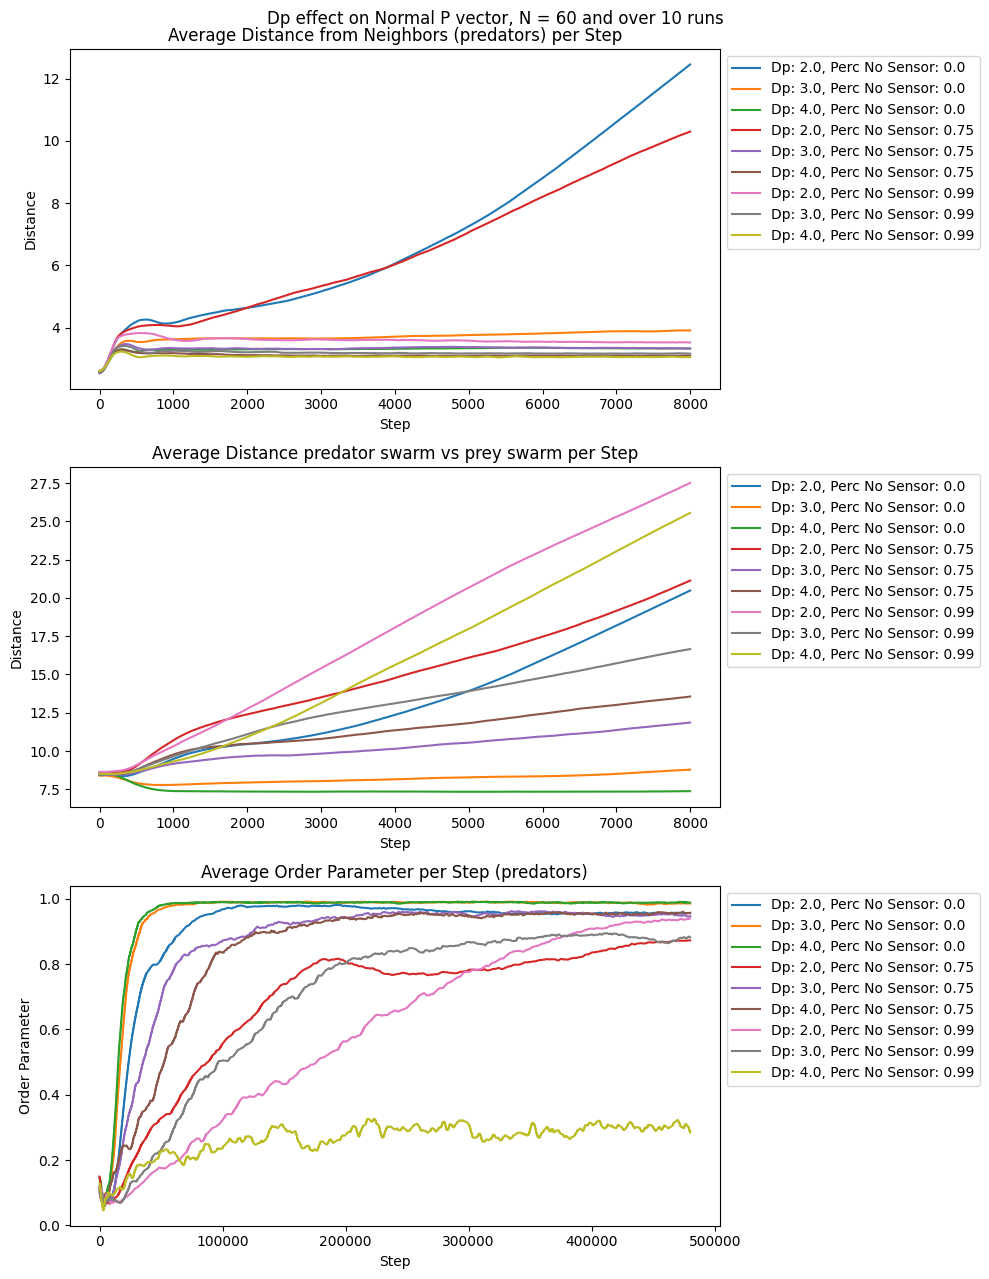

In [68]:


average_distance_from_neighbors_per_condition = {}
average_distance_from_prey_per_condition = {}
average_order_parameter_per_condition = {}




for exp_id in dfs.keys():
    for key, data in dfs[exp_id].items():
        condition = key  # condition is a tuple (Dpm, perc_no_sensor)
        if condition not in average_distance_from_neighbors_per_condition:
            average_distance_from_neighbors_per_condition[condition] = []
            average_distance_from_prey_per_condition[condition] = []
            average_order_parameter_per_condition[condition] = []
        predator_distances, prey_predator_distances, predator_order = compute_distances(data)
        average_distance_from_neighbors_per_condition[condition].append(predator_distances)
        average_distance_from_prey_per_condition[condition].append(prey_predator_distances)
        average_order_parameter_per_condition[condition].append(predator_order)

# Find the maximum number of steps across all conditions
max_steps = max(max(len(distances) for distances in condition_dict.values()) for condition_dict in [average_distance_from_neighbors_per_condition, average_distance_from_prey_per_condition, average_order_parameter_per_condition])

# Pad the arrays in each condition dictionary
for condition_dict in [average_distance_from_neighbors_per_condition, average_distance_from_prey_per_condition, average_order_parameter_per_condition]:
    for condition, distances in condition_dict.items():
        for i in range(len(distances)):
            if len(distances[i]) < max_steps:
                distances[i] = np.pad(distances[i], (0, max_steps - len(distances[i])), 'constant', constant_values=np.nan)

# Calculate the average distance from neighbors, from prey, and order parameter per step for each condition
average_distance_from_neighbors_per_step = {condition: np.nanmean(distances, axis=0) for condition, distances in average_distance_from_neighbors_per_condition.items()}
average_distance_from_prey_per_step = {condition: np.nanmean(distances, axis=0) for condition, distances in average_distance_from_prey_per_condition.items()}
average_order_parameter_per_step = {condition: np.nanmean(order, axis=0) for condition, order in average_order_parameter_per_condition.items()}
fig, axes = plt.subplots(3, 1, figsize=(10, 13))
for condition, avg_distance in average_distance_from_neighbors_per_step.items():
    Dp, perc_no_sensor = condition
    label = f'Dp: {Dp}, Perc No Sensor: {perc_no_sensor}'
    axes[0].plot(range(len(avg_distance)), avg_distance, label=label)

for condition, avg_distance in average_distance_from_prey_per_step.items():
    Dp, perc_no_sensor = condition
    label = f'Dp: {Dp}, Perc No Sensor: {perc_no_sensor}'
    axes[1].plot(range(len(avg_distance)), avg_distance, label=label)

for condition, avg_order in average_order_parameter_per_step.items():
    Dp, perc_no_sensor = condition
    label = f'Dp: {Dp}, Perc No Sensor: {perc_no_sensor}'
    axes[2].plot(range(len(avg_order)), avg_order, label=label)


axes[0].set_title('Average Distance from Neighbors (predators) per Step')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Distance')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[1].set_title('Average Distance predator swarm vs prey swarm per Step')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Distance')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

axes[2].set_title('Average Order Parameter per Step (predators)')
axes[2].set_xlabel('Step')
axes[2].set_ylabel('Order Parameter')
axes[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top to make space for the suptitle
plt.suptitle('Dp effect on Normal P vector, N = 60')
plt.show()

SensorRange-5_SensingRange-4_%NoSensor-0,0_MinDistance-4,0_PADM-yes_Dp-3,0_Kappa-3,0


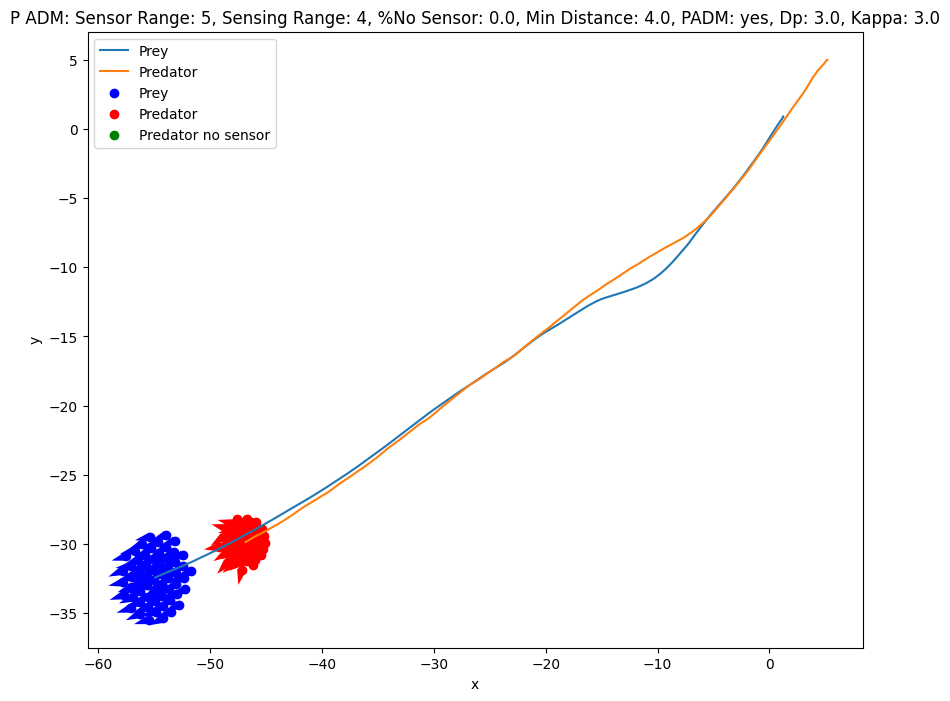

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'dataPreyPredator/test'
path2 = 'dataPreyPredator/showtestDp'
dfs = {}

files = ['Agents[60]_Preys[60]_steps[10000]_kappa[3.0]_precentageNoSensor[0.0]_minDistance[4.0]_sensingRange[4]_sensorRange[5]_pdm[True]_DpPdm[3.0]_exp[1].csv']


for file in files:
    try:
        data = pd.read_csv(f'{path}/{file}')
        dfs[file] = data
    except FileNotFoundError:
        print(f'File {file} not found')

# for file in filesDp:
#     try:
#         data = pd.read_csv(f'{path2}/{file}')
#         dfs[file] = data
#     except FileNotFoundError:
#         print(f'File {file} not found')

def plot_data_trajectory_and_last_step_pos(df: pd.DataFrame, title: str="", sanitized_title: str="") -> None:
    
    output_dir = "images"  # Directory to save images
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

    plt.figure(figsize=(10, 8))  # Adjust width and height as needed

    prey     = df[df['isPredator'] == 0]
    predator = df[df['isPredator'] == 1]

    steps = df['step'].astype(int).unique()

    trajectory_prey     = prey.groupby('step')[['x', 'y']].mean()
    trajectory_predator = predator.groupby('step')[['x', 'y']].mean()


    last_steps_positions_predators = predator[predator['step'] == predator['step'].max()]
    last_steps_positions_prey      = prey[prey['step'] == prey['step'].max()]

    plt.plot(trajectory_prey['x'], trajectory_prey['y'], label='Prey')
    plt.plot(trajectory_predator['x'], trajectory_predator['y'], label='Predator')

    plt.scatter(last_steps_positions_prey['x'], last_steps_positions_prey['y'], label='Prey', color='blue')
    # change color of the predator if no sensor
    predators_with_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 1]
    predators_without_sensor = last_steps_positions_predators[last_steps_positions_predators['distanceSensor'] == 0]
    plt.scatter(predators_with_sensor['x'], predators_with_sensor['y'], label='Predator', color='red')
    plt.scatter(predators_without_sensor['x'], predators_without_sensor['y'], label='Predator no sensor', color='green')

    prey_arrows_color = ['blue'] * len(last_steps_positions_prey)
    predator_with_sensor_arrows_color = ['red'] * len(predators_with_sensor)
    predator_without_sensor_arrows_color = ['green'] * len(predators_without_sensor)

    plt.quiver(last_steps_positions_prey['x'], last_steps_positions_prey['y'], np.cos(last_steps_positions_prey['theta']), np.sin(last_steps_positions_prey['theta']), scale=50, color=prey_arrows_color)
    plt.quiver(predators_with_sensor['x'], predators_with_sensor['y'], np.cos(predators_with_sensor['theta']), np.sin(predators_with_sensor['theta']), scale=50, color=predator_with_sensor_arrows_color)
    plt.quiver(predators_without_sensor['x'], predators_without_sensor['y'], np.cos(predators_without_sensor['theta']), np.sin(predators_without_sensor['theta']), scale=50, color=predator_without_sensor_arrows_color)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.legend()

    file_name = os.path.join(output_dir, f"{sanitized_title}.png")  # Construct the file name with the sanitized title
    plt.savefig(file_name)  # Save the plot as an image with the title as the file name

    plt.show()



def make_title(file_name: str, df: pd.DataFrame) -> str:
    # Extracting parameters from the file name
    params = file_name.split('_')

    sensor_range = None
    sensing_range = None
    no_sensor_percentage = None
    min_distance = None
    Dp = None
    pdm = None
    kappa = None

    for param in params:
        if 'sensorRange' in param:
            sensor_range = param.split('[')[-1].replace(']', '')
        elif 'sensingRange' in param:
            sensing_range = param.split('[')[-1].replace(']', '')
        elif 'precentageNoSensor' in param:
            no_sensor_percentage = param.split('[')[-1].replace(']', '')
        elif 'minDistance' in param:
            min_distance = param.split('[')[-1].replace(']', '')
        elif 'pdm' in param:
            pdm_value = param.split('[')[-1].replace(']', '').split('_')[0]
            pdm = 'yes' if pdm_value.lower() == 'true' else 'no'  # Convert to 'yes' if True, 'no' if False
        elif 'DpPdm' in param or 'Dp' in param:
            Dp = param.split('[')[-1].replace(']', '')
        elif 'kappa' in param:
            kappa = param.split('[')[-1].replace(']', '')
            

    # Constructing the sentence-based title
    title = f"Sensor Range: {sensor_range}, Sensing Range: {sensing_range}, %No Sensor: {no_sensor_percentage}, Min Distance: {min_distance}, PADM: {pdm}, Dp: {Dp}, Kappa: {kappa}"
    return title



# for file, data in dfs.items():
#     title = make_title(file, data)
#     print(title)
#     plot_data_trajectory_and_last_step_pos(data, title)






for file, data in dfs.items():
    title = make_title(file, data)
    sanitized_title = title.replace(",", "_").replace("[", "").replace("]", "").replace(" ", "").replace(".",",").replace(":","-")  # Remove commas and brackets
    print(sanitized_title)
    title = "P ADM: "+title 
    plot_data_trajectory_and_last_step_pos(data, title, sanitized_title)


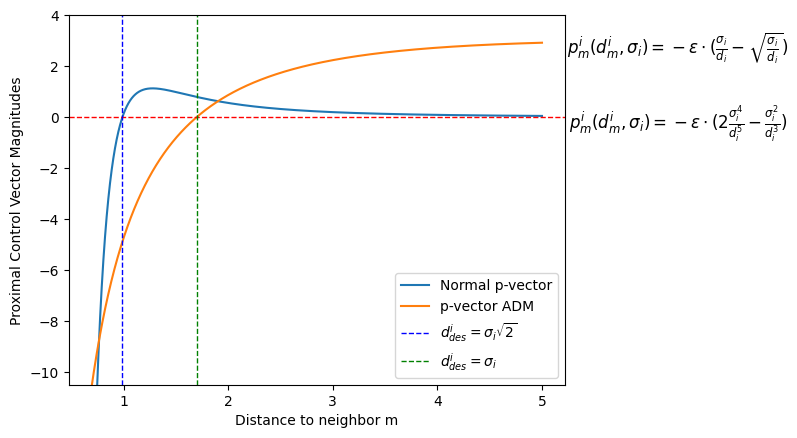

In [129]:
import numpy as np
import matplotlib.pyplot as plt
epsilon = 12.0
sigma_i = 0.7
sigma_j = 1.7
sigma   = sigma_j

distance  = np.linspace(0.69, 5.0, 100000)
distance2 = np.linspace(0.69, 5.0, 100000)


force  = -epsilon * ((2.0 * sigma_i**4) / (distance**5) - (sigma_i**2) / (distance**3)) 
# force2 = -(epsilon/5) * ((sigma_j / distance)**(3)-(sigma_j / distance)**(1/3))
force3 = (epsilon) * ((sigma / distance)**(1/2)-(sigma / distance)) #original one

plt.plot(distance, force, label='Normal p-vector')
# plt.plot(distance2, force2, label='mod ADM p-vector')
plt.plot(distance2, force3, label='p-vector ADM')
plt.axhline(0, color='red', linewidth=1, linestyle='--')

# Add vertical lines with labels
# plt.axvline(np.sqrt(2)*sigma_i, color='blue', linewidth=1, linestyle='--')
# plt.text(np.sqrt(2)*sigma_i, 0, r'$\sigma_{i}\sqrt{2}$', color='blue', ha='right',fontsize=9)

# plt.axvline(sigma_j, color='green', linewidth=1, linestyle='--')
# plt.text(sigma_j, -0, r'$\sigma_{i}$', color='green', ha='right', fontsize=12)

plt.axvline(np.sqrt(2)*sigma_i, color='blue', linewidth=1, linestyle='--', label=r'$d^i_{des}=\sigma_{i}\sqrt{2}$')
plt.axvline(sigma_j, color='green', linewidth=1, linestyle='--', label=r'$d^i_{des}=\sigma_{i}$')

plt.text(7.35, 2.5, r'$p^i_m(d^i_m,\sigma_i)=-\epsilon \cdot ( \frac{\sigma_i}{d_i}-\sqrt{\frac{\sigma_i}{d_i}} )$', color='black', ha='right', fontsize=12)
plt.text(7.35, -0.5, r'$p^i_m(d^i_m,\sigma_i)=-\epsilon \cdot(2 \frac{\sigma_i^4}{d_i^5} - \frac{\sigma_i^2}{d_i^3})  $', color='black', ha='right', fontsize=12)

# plt.axvline(0, color='red', linewidth=0.5)



plt.xlabel('Distance to neighbor m')
plt.ylabel('Proximal Control Vector Magnitudes')
# plt.title('Force vs Distance')
plt.ylim(-10.5, 4)
plt.legend(loc='best')#, bbox_to_anchor=(1, 1))
plt.show()

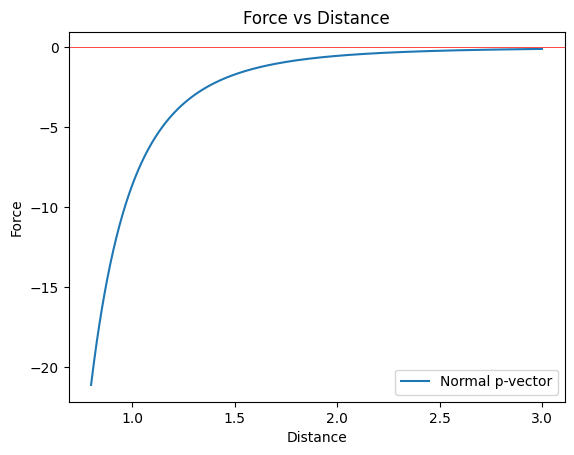

In [176]:
epsilon = 12.0
sigma_i = 0.7

distance = np.linspace(0.8, 3.0, 1000)
const = 4.0
force =  -epsilon * ((const * sigma_i**const) / (distance**const) - (sigma_i**const) / (distance**const)) 


plt.plot(distance, force, label='Normal p-vector')

plt.axhline(0, color='red', linewidth=0.5)

# Add vertical lines with labels
# plt.axvline(np.sqrt(2)*sigma_i, color='blue', linewidth=2)
# plt.text(np.sqrt(2)*sigma_i, -18, r'$\sigma_{i}\cdot\sqrt{2}$', color='blue', ha='right')

plt.xlabel('Distance')
plt.ylabel('Force')
plt.title('Force vs Distance')
plt.legend()
plt.show()

In [155]:
@latexify.function
def p_vector(distance, sigma_i):
    return -epsilon * ((2 * sigma_i**4) / (distance**5) - (sigma_i**2) / (distance**3)) 
p_vector

@latexify.function
def p_vector2(distance, sigma_j):
    return -epsilon / 2 * ((sigma_j / distance)**(3)-(sigma_j / distance)**(1/2))

@latexify.function
def p_vector3(distance, sigma):
    return epsilon / 2 * ((sigma / distance)**(1/2)-(sigma / distance))


p_vector2


In [153]:
p_vector3

In [131]:
p_vector

In [331]:
print(p_vector)
print(p_vector2)

\mathrm{p\_vector}(\mathrm{distance}, \mathrm{sigma\_i}) = -\mathrm{epsilon} \cdot \mathopen{}\left( \frac{2 \mathrm{sigma\_i}^{4}}{\mathrm{distance}^{5}} - \frac{\mathrm{sigma\_i}^{2}}{\mathrm{distance}^{3}} \mathclose{}\right)
\mathrm{p\_vector2}(\mathrm{distance}, \mathrm{sigma\_j}) = \frac{-\mathrm{epsilon}}{2} \cdot \mathopen{}\left( \mathopen{}\left( \frac{\mathrm{sigma\_j}}{\mathrm{distance}} \mathclose{}\right)^{3} - \mathopen{}\left( \frac{\mathrm{sigma\_j}}{\mathrm{distance}} \mathclose{}\right)^{\frac{1}{2}} \mathclose{}\right)


In [ ]:
    # def generate_agents_and_preys(self) -> Tuple[np.array, np.array]:

    #     # Set the seed for random number generation
    #     # np.random.seed(seed=73)
    #     boundaryX, boundaryY = self.boundaries
    #     boundaries = (10, 10) if self.boundaries == [0,0] else (boundaryX, boundaryY) # if boundaries are not defined, then boundless environment
    #     # Generate 2D agents and preys matrices
    #     agents = np.ones((self.N, 5))  # Each row represents an agent: [x, y, theta, sesing_yes/no,id]
    #     preys = np.zeros((self.N_preys, 4))  # Each row represents a prey: [x, y, theta, id]
    #     # assign non sensing agents
    #     agents = self.no_sensor_agents(self.no_sensor, agents)
    #     # sort agents by sensing_yes/no
    #     # agents = agents[agents[:, 3].argsort()]
    #     agents = agents[agents[:, 3].argsort()[::-1]]

    #     # Assign ids to the agents and preys
    #     agents[:, 4] = np.arange(self.N)
    #     preys[:, 3] = np.arange(self.N_preys)

    #     # Generate random x, y for the first agent and prey
        
    #     # x = np.random.randint(0, boundaries[1]-5)
    #     # y = np.random.randint(0, boundaries[1]-5)

    #     x = boundaries[1] // 2
    #     y = boundaries[1] // 2

    #     agents[0, :2] = np.array([x, y])

    #     # generate random x, y for the first prey within a distance of 2 from the first agent
    #     min_distance = self.min_distance
    #     x_prey = x + np.random.choice([-min_distance, min_distance])
    #     y_prey = y + np.random.choice([-min_distance, min_distance])
        
    #     theta = np.random.uniform(-np.pi, np.pi)  # Random theta for the first agent
    #     theta_prey = np.random.uniform(-np.pi, np.pi)  # Random theta for the first prey
        
    #     preys[0, :2] = np.array([x_prey, y_prey])
    #     agents[0, 2] = theta
    #     preys[0, 2] = theta_prey
    #     # Generate random relative positions for the rest of the agents and preys
    #     for i in range(1, self.N):
    #         relative_x = np.random.uniform(-self.sigma_i, self.sigma_i)
    #         relative_y = np.random.uniform(-self.sigma_i, self.sigma_i)

    #         # Translate relative positions to absolute positions based on the first agent
    #         x_i = x + relative_x
    #         y_i = y + relative_y
    #         agents[i, 0] = x_i
    #         agents[i, 1] = y_i
    #         agents[i, 2] = np.random.uniform(-np.pi, np.pi) # Random theta for the rest of the agents

    #     for i in range(1, self.N_preys):
    #         relative_x = np.random.uniform(-self.sigma_i, self.sigma_i)
    #         relative_y = np.random.uniform(-self.sigma_i, self.sigma_i)


    #         x_i = x_prey + relative_x
    #         y_i = y_prey + relative_y
    #         preys[i, 0] = x_i
    #         preys[i, 1] = y_i
    #         preys[i, 2] = np.random.uniform(-np.pi, np.pi) # Random theta for the rest of the preys

    #     return agents, preys


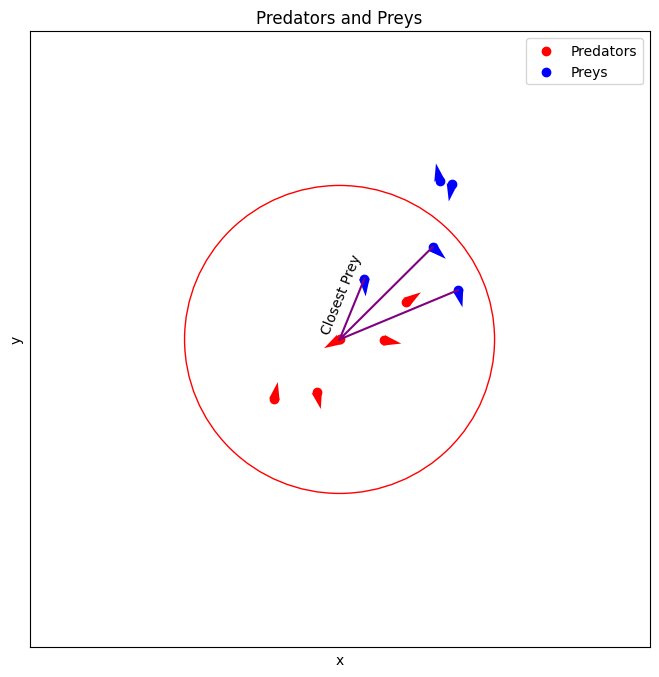

In [187]:
N = 5
predators = np.zeros((N, 3)) # x, y, theta
preys = np.zeros((N, 3)) # x, y, theta

np.random.seed(seed=800)


# Generate random x, y for the first predator and prey
x = 0
y = 0
x_prey = 0.6
y_prey = 0.6
theta = np.random.uniform(-np.pi, np.pi)  # Random theta for the first predator
theta_prey = np.random.uniform(-np.pi, np.pi)  # Random theta for the first prey

predators[0, :2] = np.array([x, y])
preys[0, :2] = np.array([x_prey, y_prey])
predators[0, 2] = theta

preys[0, 2] = theta_prey

# Generate random relative positions for the rest of the predators and preys
for i in range(1, N):
    relative_x = np.random.uniform(-0.5, 0.5)
    relative_y = np.random.uniform(-0.5, 0.5)

    # Translate relative positions to absolute positions based on the first predator
    x_i = x + relative_x
    y_i = y + relative_y
    predators[i, 0] = x_i
    predators[i, 1] = y_i
    predators[i, 2] = np.random.uniform(-np.pi, np.pi) # Random theta for the rest of the predators

for i in range(1, N):
    relative_x = np.random.uniform(-0.5, 0.5)
    relative_y = np.random.uniform(-0.5, 0.5)

    x_i = x_prey + relative_x
    y_i = y_prey + relative_y
    preys[i, 0] = x_i
    preys[i, 1] = y_i
    preys[i, 2] = np.random.uniform(-np.pi, np.pi) # Random theta for the rest of the preys


# draw circles to one of the predators


fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.scatter(predators[:, 0], predators[:, 1], color='red', label='Predators')
ax.scatter(preys[:, 0], preys[:, 1], color='blue', label='Preys')
ax.quiver(predators[:, 0], predators[:, 1], np.cos(predators[:, 2]), np.sin(predators[:, 2]), color='red', scale=35)
ax.quiver(preys[:, 0], preys[:, 1], np.cos(preys[:, 2]), np.sin(preys[:, 2]), color='blue', scale=35)

# draw circle for the first predator
# draw circle for the first predator
circle_radius = 1
circle = plt.Circle((predators[0, 0], predators[0, 1]), circle_radius, color='red', fill=False)
ax.add_artist(circle)
# draw lines to preys inside the circle and find the closest one
closest_prey = None
shortest_distance = float('inf')
for prey in preys:
    distance_to_prey = np.sqrt((prey[0] - predators[0, 0])**2 + (prey[1] - predators[0, 1])**2)
    if distance_to_prey <= circle_radius:
        ax.plot([predators[0, 0], prey[0]], [predators[0, 1], prey[1]], color='purple')
        if distance_to_prey < shortest_distance:
            shortest_distance = distance_to_prey
            closest_prey = prey

# add a text label to the closest prey
if closest_prey is not None:
    dx = closest_prey[0] - predators[0, 0]
    dy = closest_prey[1] - predators[0, 1]
    angle = np.degrees(np.arctan2(dy, dx))  # Calculate the angle of the line
    ax.text(closest_prey[0], closest_prey[1]-0.35, 'Closest Prey', color='black', rotation=angle, ha='right')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([])  # Hide x-axis ticks
ax.set_yticks([]) 
ax.set_title('Predators and Preys')
ax.legend()
plt.show()

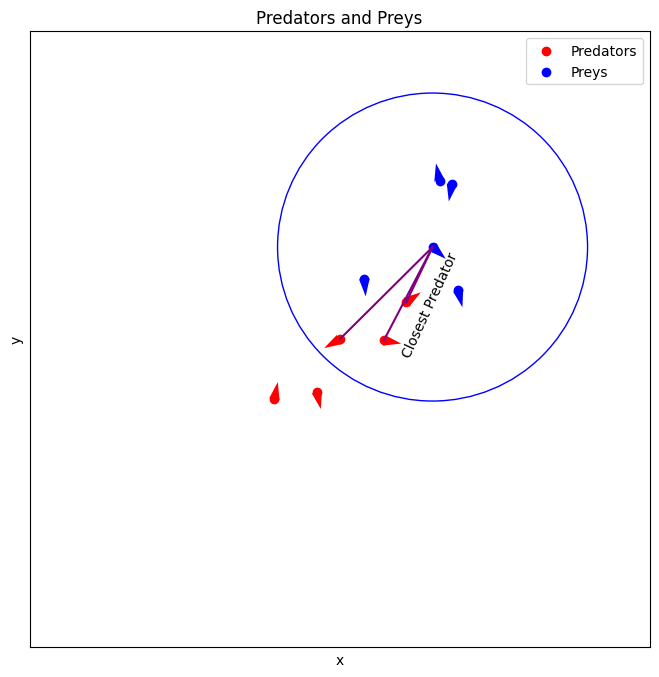

In [207]:
N = 5
predators = np.zeros((N, 3)) # x, y, theta
preys = np.zeros((N, 3)) # x, y, theta

np.random.seed(seed=800)


# Generate random x, y for the first predator and prey
x = 0
y = 0
x_prey = 0.6
y_prey = 0.6
theta = np.random.uniform(-np.pi, np.pi)  # Random theta for the first predator
theta_prey = np.random.uniform(-np.pi, np.pi)  # Random theta for the first prey

predators[0, :2] = np.array([x, y])
preys[0, :2] = np.array([x_prey, y_prey])
predators[0, 2] = theta

preys[0, 2] = theta_prey

# Generate random relative positions for the rest of the predators and preys
for i in range(1, N):
    relative_x = np.random.uniform(-0.5, 0.5)
    relative_y = np.random.uniform(-0.5, 0.5)

    # Translate relative positions to absolute positions based on the first predator
    x_i = x + relative_x
    y_i = y + relative_y
    predators[i, 0] = x_i
    predators[i, 1] = y_i
    predators[i, 2] = np.random.uniform(-np.pi, np.pi) # Random theta for the rest of the predators

for i in range(1, N):
    relative_x = np.random.uniform(-0.5, 0.5)
    relative_y = np.random.uniform(-0.5, 0.5)

    x_i = x_prey + relative_x
    y_i = y_prey + relative_y
    preys[i, 0] = x_i
    preys[i, 1] = y_i
    preys[i, 2] = np.random.uniform(-np.pi, np.pi) # Random theta for the rest of the preys


# draw circles to one of the predators


fig, ax = plt.subplots(figsize=(8,8))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.scatter(predators[:, 0], predators[:, 1], color='red', label='Predators')
ax.scatter(preys[:, 0], preys[:, 1], color='blue', label='Preys')
ax.quiver(predators[:, 0], predators[:, 1], np.cos(predators[:, 2]), np.sin(predators[:, 2]), color='red', scale=35)
ax.quiver(preys[:, 0], preys[:, 1], np.cos(preys[:, 2]), np.sin(preys[:, 2]), color='blue', scale=35)

# draw circle for the first prey
circle_radius = 1
circle = plt.Circle((preys[0, 0], preys[0, 1]), circle_radius, color='blue', fill=False)
ax.add_artist(circle)

# draw lines to predators inside the circle and find the closest one
closest_predator = None
shortest_distance = float('inf')
for predator in predators:
    distance_to_predator = np.sqrt((predator[0] - preys[0, 0])**2 + (predator[1] - preys[0, 1])**2)
    if distance_to_predator <= circle_radius:
        ax.plot([preys[0, 0], predator[0]], [preys[0, 1], predator[1]], color='purple')
        if distance_to_predator < shortest_distance:
            shortest_distance = distance_to_predator
            closest_predator = predator

# add a text label to the closest predator
if closest_predator is not None:
    dx = closest_predator[0] - preys[0, 0]
    dy = closest_predator[1] - preys[0, 1]
    angle = np.degrees(np.arctan2(dy, dx))  # Calculate the angle of the line
    ax.text(closest_predator[0]+0.35, closest_predator[1]-0.35, 'Closest Predator', color='black', rotation=-angle-50, ha='right')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xticks([])  # Hide x-axis ticks
ax.set_yticks([]) 
ax.set_title('Predators and Preys')
ax.legend()
plt.show()

# Part 2


In [5]:
# experiments padm 
experiment_id_ =  [str(i) for i in range(1, 50+1)]
N_preys                    = [30]
N_agent                    = [30]
min_distance               = [4.0]
sensing_range              = [3]
sensor_range               = [6]
percentage_no_sensor       = [0.0, 0.75, 0.99]
kappas                     = [3.0]
Dps                        = [3.0]
Dpms                       = [3.0]
pdm                        = True
total_steps_per_simulation = 10000
path = 'dataPreyPredator/experiments'

dfs = {experiment_id: {} for experiment_id in experiment_id_}
i = 1
for experiment_id in experiment_id_:
    for kappa in kappas:
        for n_prey in N_preys:
            for perc_no_sensor in percentage_no_sensor:
                for n_agent in N_agent:
                    for s_range in sensing_range:
                        for sensor_r in sensor_range:
                            for min_d in min_distance:
                                for Dp in Dps:
                                    for Dpm in Dpms:
                                        try:
                                            data = pd.read_csv(
                                                f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dp}]_exp[{experiment_id}].csv'
                                            )
                                            dfs[experiment_id][perc_no_sensor] = data
                                            # plot_data(data, f'kappa: {kappa}, experiment_id: {experiment_id}, N_agent: {n_agent}, N_prey: {n_prey}, min_distance: {min_d}, sensing_range: {s_range}, sensor_range: {sensor_r}, perc_no_sensor: {perc_no_sensor},i: {i}')
                                            # i += 1
                                        except FileNotFoundError:
                                            print(
                                                f'{path}/Agents[{n_agent}]_Preys[{n_prey}]_steps[{total_steps_per_simulation}]_kappa[{kappa}]_precentageNoSensor[{perc_no_sensor}]_minDistance[{min_d}]_sensingRange[{s_range}]_sensorRange[{sensor_r}]_pdm[{pdm}]_DpPdm[{Dp}]_exp[{experiment_id}].csv'
                                            )




In [41]:
import numpy as np

# Initialize dictionaries to store the sum of distances and orders for each percentage of no sensor
sum_distance_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}
sum_order_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}
sum_dist_neigh_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}
# Initialize dictionaries to store the sum of squared distances and orders for each percentage of no sensor
sum_squared_distance_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}
sum_squared_order_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}
sum_squared_dist_neigh_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}
# Initialize dictionaries to count the number of values for each percentage of no sensor
count_per_perc_no_sensor = {perc_no_sensor: 0 for perc_no_sensor in percentage_no_sensor}

# Loop over each experiment
for exp_id in dfs.keys():
    for perc_no_sensor, data in dfs[exp_id].items():
        avg_dist_neigh, avg_distance, avg_order = compute_distances(data)
        sum_distance_per_perc_no_sensor[perc_no_sensor] += avg_distance * len(data)  # Multiply by the number of data points
        sum_squared_distance_per_perc_no_sensor[perc_no_sensor] += (avg_distance ** 2) * len(data)  # Squared distance
        sum_order_per_perc_no_sensor[perc_no_sensor] += avg_order * len(data)  # Multiply by the number of data points
        sum_squared_order_per_perc_no_sensor[perc_no_sensor] += (avg_order ** 2) * len(data)  # Squared order
        sum_dist_neigh_per_perc_no_sensor[perc_no_sensor] += avg_dist_neigh * len(data)
        sum_squared_dist_neigh_per_perc_no_sensor[perc_no_sensor] += (avg_dist_neigh ** 2) * len(data)
        count_per_perc_no_sensor[perc_no_sensor] += len(data)

# Compute the averages
avg_distance_per_step_per_perc_no_sensor = {perc_no_sensor: sum_distance_per_perc_no_sensor[perc_no_sensor] / count_per_perc_no_sensor[perc_no_sensor] for perc_no_sensor in percentage_no_sensor}
avg_order_per_step_per_perc_no_sensor = {perc_no_sensor: sum_order_per_perc_no_sensor[perc_no_sensor] / count_per_perc_no_sensor[perc_no_sensor] for perc_no_sensor in percentage_no_sensor}
avg_dist_neigh_per_step_per_perc_no_sensor = {perc_no_sensor: sum_dist_neigh_per_perc_no_sensor[perc_no_sensor] / count_per_perc_no_sensor[perc_no_sensor] for perc_no_sensor in percentage_no_sensor}

# Compute the standard deviations
std_distance_per_step_per_perc_no_sensor = {perc_no_sensor: np.sqrt((sum_squared_distance_per_perc_no_sensor[perc_no_sensor] / count_per_perc_no_sensor[perc_no_sensor]) - (avg_distance_per_step_per_perc_no_sensor[perc_no_sensor] ** 2)) for perc_no_sensor in percentage_no_sensor}
std_order_per_step_per_perc_no_sensor = {perc_no_sensor: np.sqrt((sum_squared_order_per_perc_no_sensor[perc_no_sensor] / count_per_perc_no_sensor[perc_no_sensor]) - (avg_order_per_step_per_perc_no_sensor[perc_no_sensor] ** 2)) for perc_no_sensor in percentage_no_sensor}
std_dist_neigh_per_step_per_perc_no_sensor = {perc_no_sensor: np.sqrt((sum_squared_dist_neigh_per_perc_no_sensor[perc_no_sensor] / count_per_perc_no_sensor[perc_no_sensor]) - (avg_dist_neigh_per_step_per_perc_no_sensor[perc_no_sensor] ** 2)) for perc_no_sensor in percentage_no_sensor}


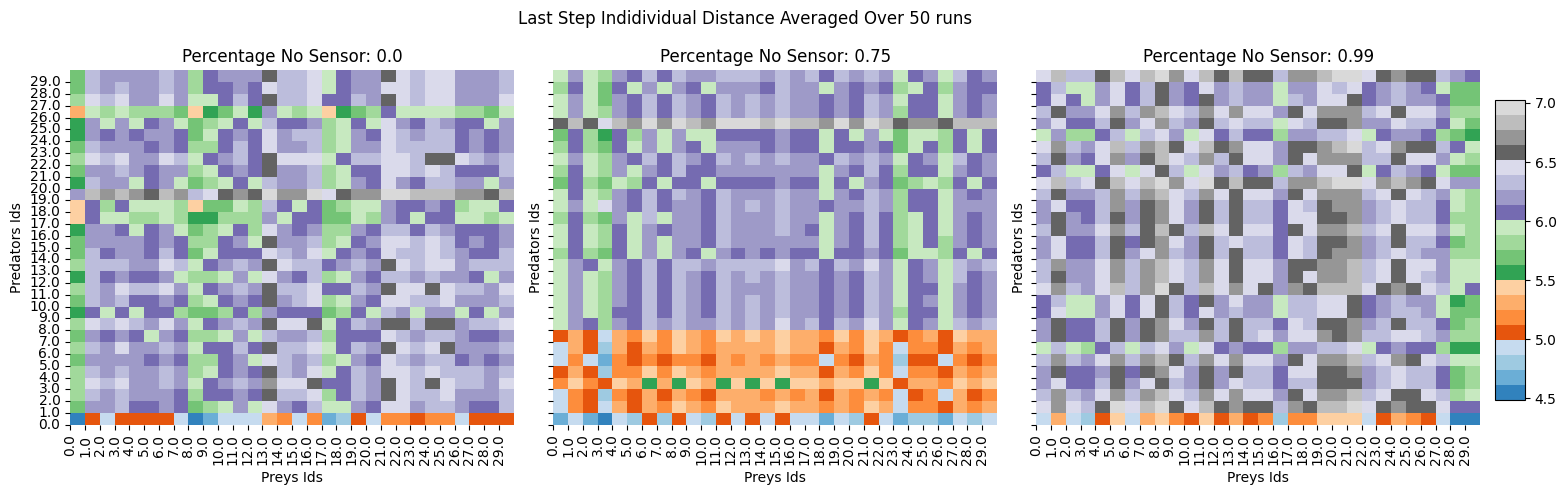

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_distance(agent, prey):
    return np.sqrt((agent[0] - prey[0])**2 + (agent[1] - prey[1])**2)

# Initialize a dictionary to store the matrices for each percentage of no sensor
matrices_per_perc_no_sensor = {perc_no_sensor: [] for perc_no_sensor in percentage_no_sensor}
prey_ids = None
predator_ids = None

# ids_with_sensor = {perc_no_sensor: [] for perc_no_sensor in percentage_no_sensor}
# Loop over each experiment
for exp_id in dfs.keys():
    for perc_no_sensor, data in dfs[exp_id].items():
        predatores = data[data['isPredator'] == 1]
        preys = data[data['isPredator'] == 0]

        prey_ids = preys['id'].unique()
        predator_ids = predatores['id'].unique()

        # Initialize a matrix of zeros with shape (number of predators, number of preys)
        matrix = np.zeros((len(predatores['id'].unique()), len(preys['id'].unique())))

        # ids_with_sensor[perc_no_sensor].append(predatores[predatores['distanceSensor'] == 1]['id'].unique())

        # Take the last step
        predatores = predatores[predatores['step'] == predatores['step'].max()]
        preys = preys[preys['step'] == preys['step'].max()]
        predatores = predatores[['x', 'y', 'theta']].values
        preys = preys[['x', 'y', 'theta']].values

        for i, predator in enumerate(predatores):
            for j, prey in enumerate(preys):
                matrix[i, j] = compute_distance(predator, prey)
        matrices_per_perc_no_sensor[perc_no_sensor].append(matrix)

# Compute the average matrix for each percentage of no sensor
avg_matrices_per_perc_no_sensor = {perc_no_sensor: np.mean(matrices_per_perc_no_sensor[perc_no_sensor], axis=0) for perc_no_sensor in percentage_no_sensor}

import seaborn as sns

fig, axes = plt.subplots(1,len(percentage_no_sensor), figsize=(15, 5), sharey=True)

# Create a colormap
cmap = plt.get_cmap('tab20c')

for i, perc_no_sensor in enumerate(percentage_no_sensor):
    matrix = avg_matrices_per_perc_no_sensor[perc_no_sensor]
    sns.heatmap(matrix, cmap=cmap, annot=False, ax=axes[i], cbar=False)  # Remove individual colorbars
    axes[i].set_title(f'Percentage No Sensor: {perc_no_sensor}')
    axes[i].set_xlabel('Preys Ids')
    axes[i].set_ylabel('Predators Ids')

    # Assuming predator_ids and prey_ids are lists of unique IDs
    axes[i].set_xticks([int(i) for i in range(len(prey_ids))]) 
    axes[i].set_yticks([int(i) for i in range(len(predator_ids))])

    # Create a color list for yticklabels
    # color_list = ['red' if distance_sensor == 1 else 'black' for distance_sensor in dfs[exp_id][perc_no_sensor]['distanceSensor']]

    axes[i].set_xticklabels(prey_ids, rotation=90)
    axes[i].set_yticklabels(predator_ids, rotation=0)  # Pass color list to set_yticklabels

    # axes[i].xaxis.tick_top()
    axes[i].invert_yaxis() 

plt.suptitle('Last Step Indidividual Distance Averaged Over 50 runs')
# Add a colorbar to the figure
cbar_ax = fig.add_axes([1, 0.2, 0.02, 0.6])  # Adjust these values to move the colorbar
fig.colorbar(axes[0].collections[0], cax=cbar_ax)

plt.tight_layout()
plt.show()

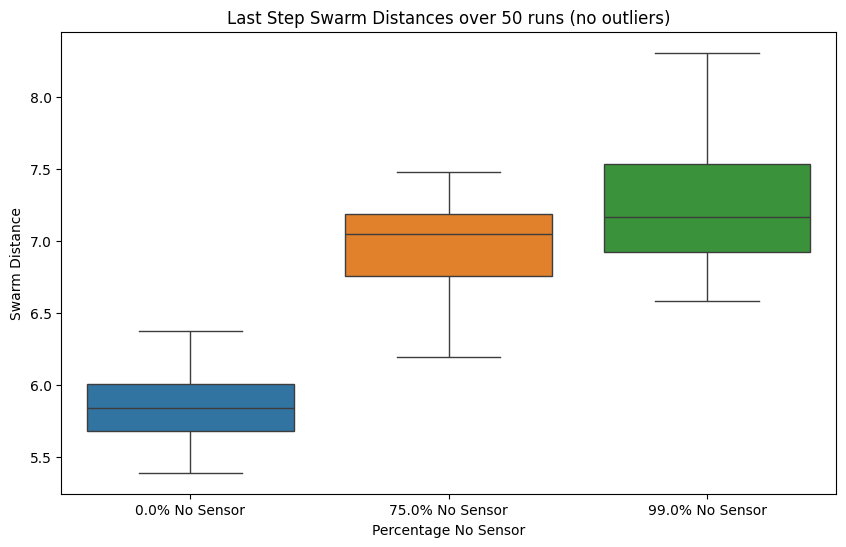

In [136]:
# make a boxplot for ditances predator-prey swarm for each percentage of no sensor
# 

def compute_swarm_distances(predator, preys):
    pred_center_of_mass = np.mean(predator, axis=0)
    prey_center_of_mass = np.mean(preys, axis=0)
    return np.sqrt((pred_center_of_mass[0] - prey_center_of_mass[0])**2 + (pred_center_of_mass[1] - prey_center_of_mass[1])**2)

swarm_distances_per_perc_no_sensor = {perc_no_sensor: [] for perc_no_sensor in percentage_no_sensor}

for exp_id in dfs.keys():
    for perc_no_sensor, data in dfs[exp_id].items():
        predatores = data[data['isPredator'] == 1]
        preys = data[data['isPredator'] == 0]
        # Take the last step
        predatores = predatores[predatores['step'] == predatores['step'].max()]
        preys = preys[preys['step'] == preys['step'].max()]

        predatores = predatores[['x', 'y']].values
        preys = preys[['x', 'y']].values

        swarm_distance = compute_swarm_distances(predatores, preys)

        swarm_distances_per_perc_no_sensor[perc_no_sensor].append(swarm_distance)

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=list(swarm_distances_per_perc_no_sensor.values()), ax=ax, showfliers=False)  # Set showfliers to False
ax.set_xticklabels([f'{perc_no_sensor * 100}% No Sensor' for perc_no_sensor in percentage_no_sensor])
ax.set_xlabel('Percentage No Sensor')
ax.set_ylabel('Swarm Distance')
ax.set_title('Last Step Swarm Distances over 50 runs (no outliers)')
plt.show()



        

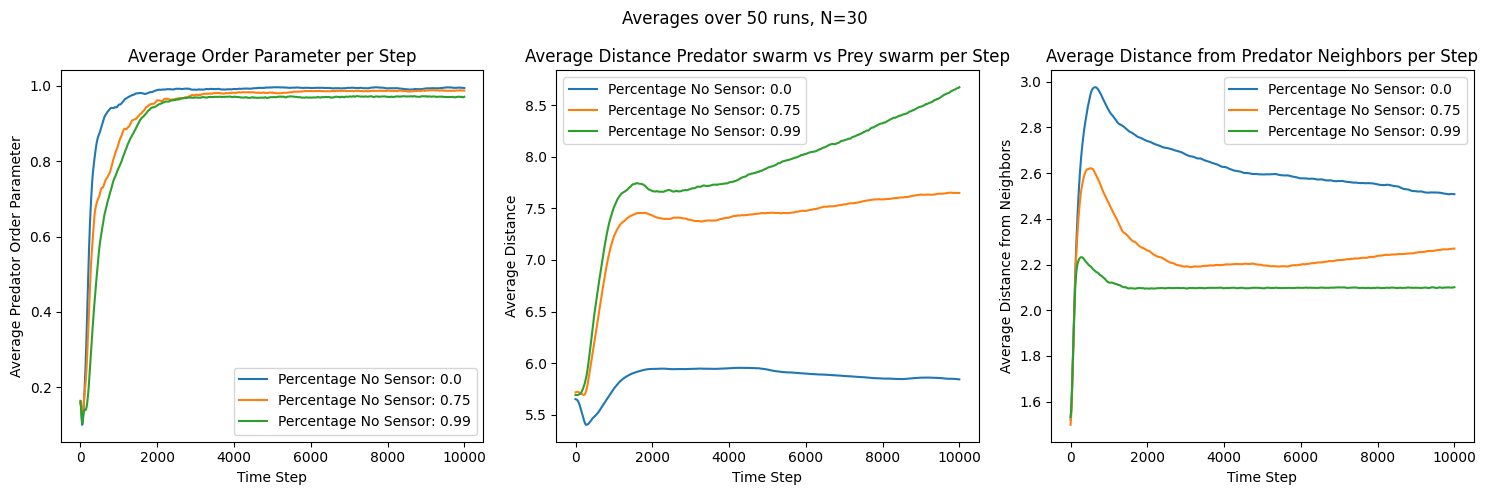

In [48]:

fig, ax = plt.subplots(1,3, figsize=(15, 5))

for perc_no_sensor, avg_order_per_step in avg_order_per_step_per_perc_no_sensor.items():
    ax[0].plot(range(len(avg_order_per_step)),avg_order_per_step, label=f'Percentage No Sensor: {perc_no_sensor}')


plt.suptitle('Averages over 50 runs, N=30')
# Add labels and title
# ax[2].axhline(1.7, color='red', linewidth=1, linestyle='--', label=r'$\sigma_c (no-sensor)=1.7$')
ax[0].set_xlabel('Time Step')
ax[0].set_ylabel('Average Predator Order Parameter')
ax[0].set_title('Average Order Parameter per Step')
# Add a legend
ax[0].legend()
# Show the plot
# plt.show()

for perc_no_sensor, avg_distance_per_step in avg_distance_per_step_per_perc_no_sensor.items():
    ax[1].plot(range(len(avg_distance_per_step)), avg_distance_per_step, label=f'Percentage No Sensor: {perc_no_sensor}')

# Add labels and title
ax[1].set_xlabel('Time Step')
ax[1].set_ylabel('Average Distance')
ax[1].set_title('Average Distance Predator swarm vs Prey swarm per Step')
# Add a legend
ax[1].legend()

for perc_no_sensor, avg_dist_neigh_per_step in avg_dist_neigh_per_step_per_perc_no_sensor.items():
    ax[2].plot(range(len(avg_dist_neigh_per_step)), avg_dist_neigh_per_step, label=f'Percentage No Sensor: {perc_no_sensor}')

# Add labels and title
ax[2].set_xlabel('Time Step')
ax[2].set_ylabel('Average Distance from Neighbors')
ax[2].set_title('Average Distance from Predator Neighbors per Step')
# Add a legend
ax[2].legend()
plt.tight_layout()
plt.show()



